In [1]:
!pip install --upgrade matplotlib > None

In [2]:
!pip install seaborn > None

In [3]:
!pip install numpy scipy scikit-learn > None

In [4]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_score, recall_score, f1_score, fbeta_score

# **Введение**

Учебное исследование выполняется на наборе данных с Kaggle.com: https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009

Впервые, набор данных был представлен в следующем исследовании:

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

Набор данных представляет собой физико-химические характеристики красного вина:
1. фиксированная кислотность
2. летучая кислотность
3. лимонная кислота
4. остаточный сахар
5. хлориды
6. свободный диоксид серы
7. общий диоксид серы
8. плотность
9. pH
10. сульфаты
11. спирт 
 
Целевая величина - экспертная оценка качества вина.




# **Придумаем искуственную бизнес-задачу:**

Необходимо на основе химических данных выделять:
- "хорошее" вино с оценкой более 6.5 для отправки в фирменные магазины
- "плохое" вино с оценкой ниже 4.5 - брак, отправляем на уксус:)
- все остальное вино называем "посредственным" и отправляем в супермаркеты

Для формирования требований к качеству модели введем следующие условия, к которым мы должны стремиться при разработке:

- в фирменные магазины должно поступать только "хорошее" вино, при этом мы не должны отсеивать более 20% от всего "хорошего" вина
- "плохое" вино не должно поступать в магазины, при этом количество выявленного моделью "плохого" вина не должно превышать его истинное количество более чем на 50%.

Не уверен, что цель будет достигнута, но будем к ней стремиться


# **1.Выбрать и обосновать метрику для измерения качества.**

Сначала придумаем как решать задачу.

Будем обучать два классификатора по принципу One-vs-All:

- для первого 1 - хорошее вино, 0 - все остальное
- для второго 1 - плохое вино, 0 - все остальное

Для первого - стараемся максимизировать Precision, при этом Recall не должен быть меньше 0.8. Качество классификатора оценим Fbeta мерой c beta = 0.5.

Для второго - стараемся максимизировать Recall, при этом Precision не должен быть меньше 0.67, Качество классификатора оценим Fbeta мерой c beta = 2.

Для оценки качества "полной" модели усредним Fbeta-меру, посчитанную для каждого из классификаторов.

Не факт, что идея хорошая, но мы же учимся


# **2.Провести EDA на своих данных**

Загрузим данные и посмотрим на них.

In [5]:
path = 'WineQT.csv'
data = pd.read_csv(path, index_col='Id')
df = data.copy()
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Кажется, все столбцы численные - отлично.

Теперь посмотрим на общие характеристики датасета: размер, типы данных, пустые строки, описание численных данных.

In [6]:
df.shape

(1143, 12)

In [7]:
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [8]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [9]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Действительно, все данные числовые, пропусков нет. Судя по процентилям целевой переменной данные несбалансированы по классам. Большую часть составляют "посредственные" вина. Проверим это чуть позже.

Сейчас посмотрим на количество уникальных значений в строках и проверим наличие повторяющихся строк.

In [10]:
df.nunique()

fixed acidity            91
volatile acidity        135
citric acid              77
residual sugar           80
chlorides               131
free sulfur dioxide      53
total sulfur dioxide    138
density                 388
pH                       87
sulphates                89
alcohol                  61
quality                   6
dtype: int64

In [11]:
df.value_counts()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide  density  pH    sulphates  alcohol  quality
7.5            0.510             0.02         1.7             0.084      13.0                 31.0                  0.99538  3.36  0.54       10.5     6          4
6.7            0.460             0.24         1.7             0.077      18.0                 34.0                  0.99480  3.39  0.60       10.6     6          4
9.3            0.360             0.39         1.5             0.080      41.0                 55.0                  0.99652  3.47  0.73       10.9     6          3
9.9            0.540             0.45         2.3             0.071      16.0                 40.0                  0.99910  3.39  0.62       9.4      5          3
6.0            0.500             0.00         1.4             0.057      15.0                 26.0                  0.99448  3.36  0.45       9.5      5          3
                     

В данных есть повторяющиеся строки. Около 10 % от всего датасета. Избавимся от них. 

In [12]:
df_uniq = pd.DataFrame([list(tup) for tup in df.value_counts().index], columns=df.columns)
df_uniq.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000
mean,8.288507,0.533541,0.268802,2.524411,0.087187,15.648821,46.325639,0.996700,3.311503,0.656817,10.452456,5.641454
std,1.741324,0.183167,0.196229,1.314850,0.048506,10.176525,33.123533,0.001916,0.157775,0.167542,1.095064,0.811744
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,21.000000,0.995572,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,38.000000,0.996665,3.310000,0.620000,10.200000,6.000000
75%,9.100000,0.645000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997827,3.400000,0.720000,11.200000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Посмотрим на отношения каждого из признаком с целевой переменной.

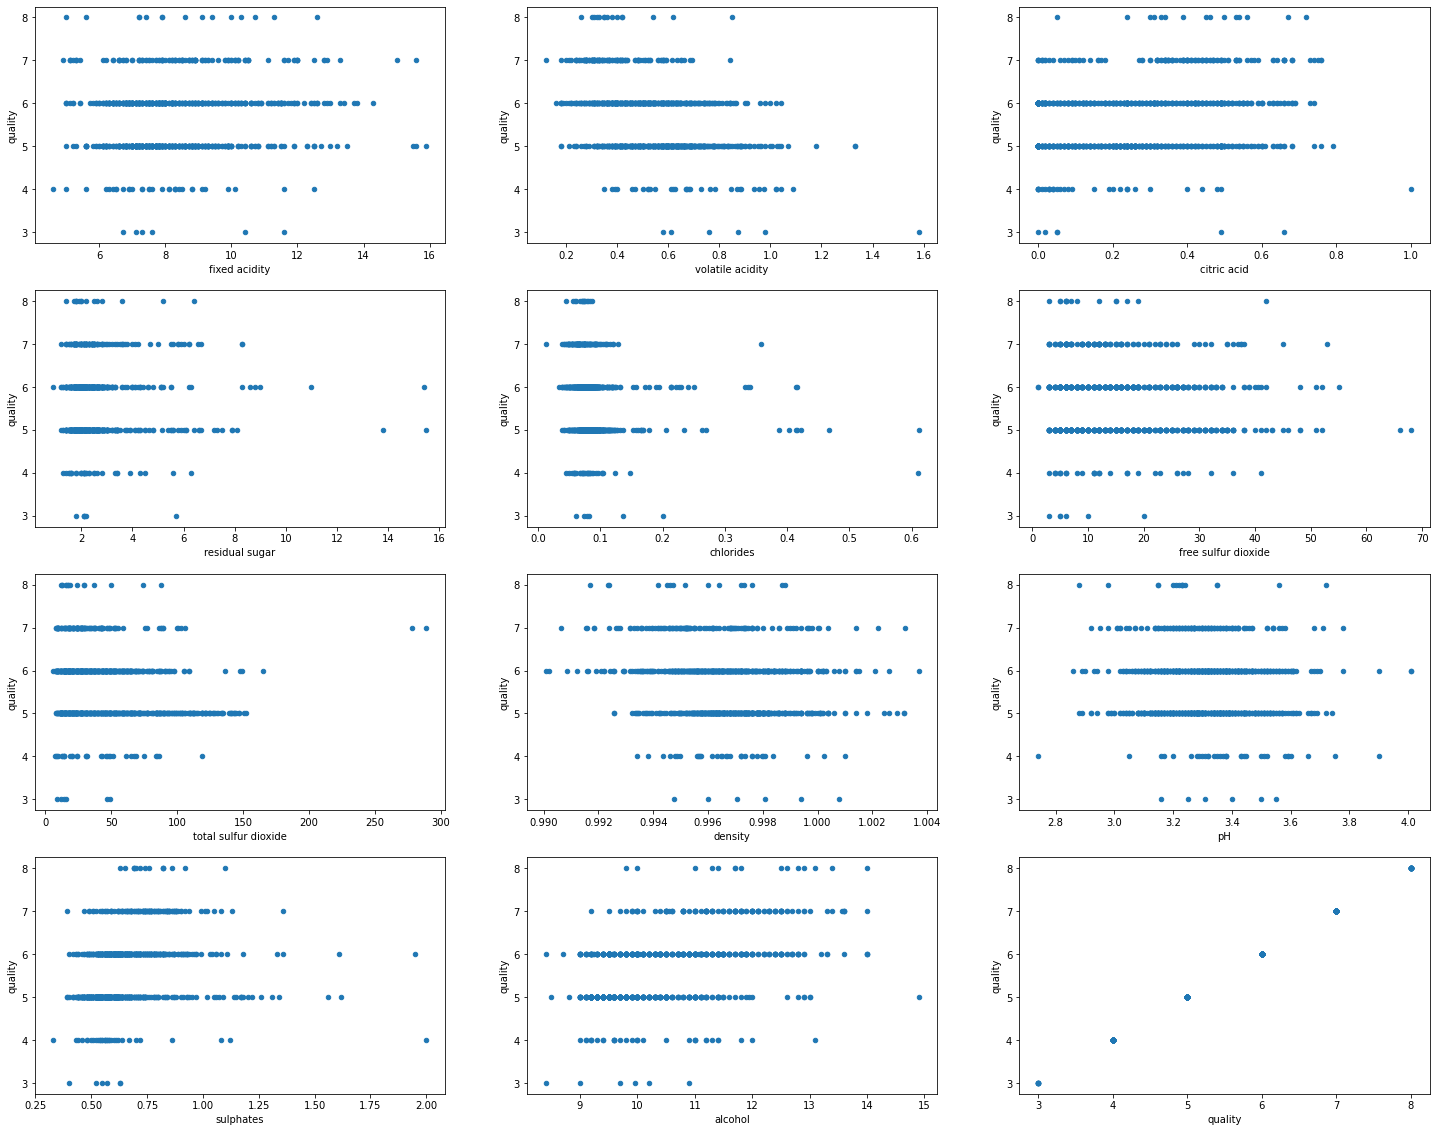

In [13]:
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (25, 20))
for idx, feature in enumerate(df_uniq.columns):
    df_uniq.plot(feature, 'quality', subplots = True, kind = "scatter", ax = axes[idx // 3, idx % 3])

Явных зависимостей не наблюдается.

Разделим вино на "категории" и помотрим на распределение по каждому из признаков.

In [14]:
target = []
for qual in df_uniq['quality']:
  if qual > 6:
    targ = 'good'
  elif qual < 5:
    targ = 'bad'
  else:
    targ = 'satisfied'
  target.append(targ)
df_mod = df_uniq.iloc[:,0:11]
df_mod['target'] = target
features = df_mod.columns[df_mod.columns != 'target']
#print(features)

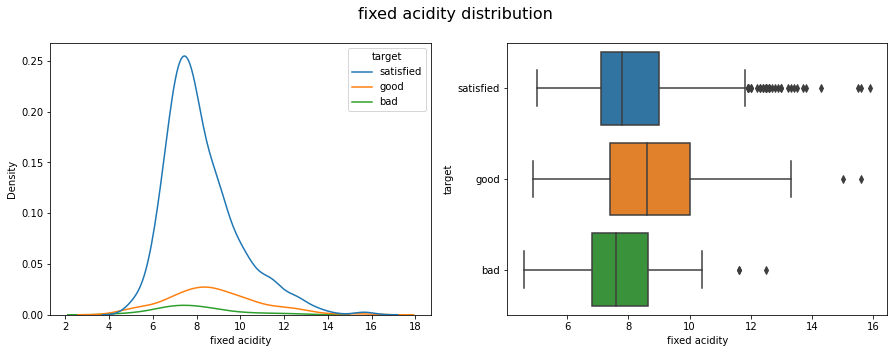

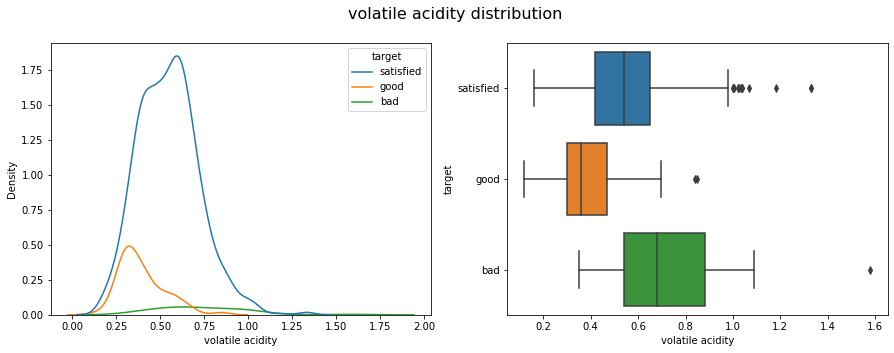

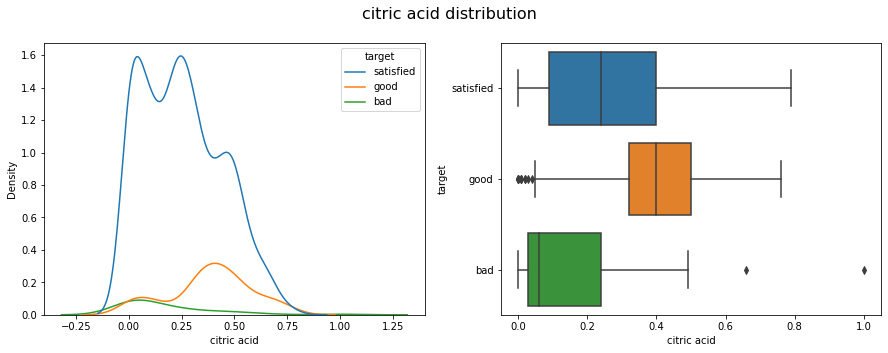

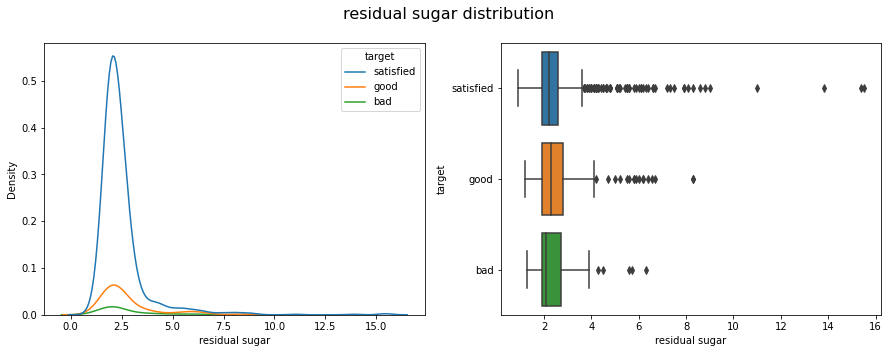

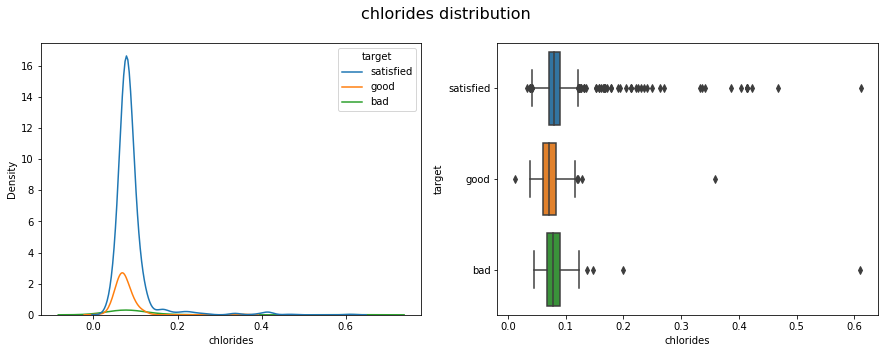

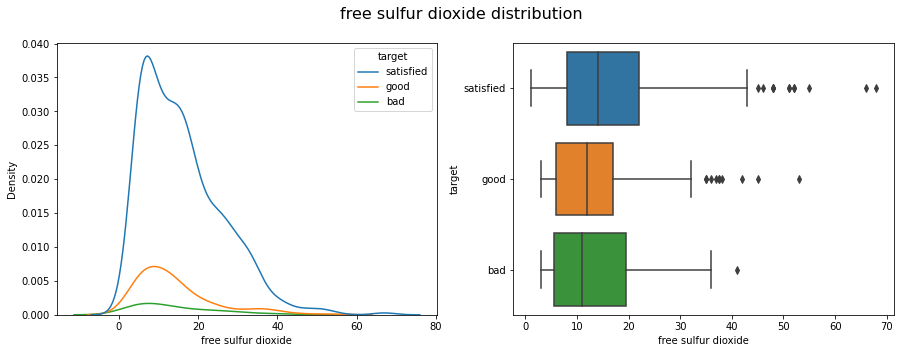

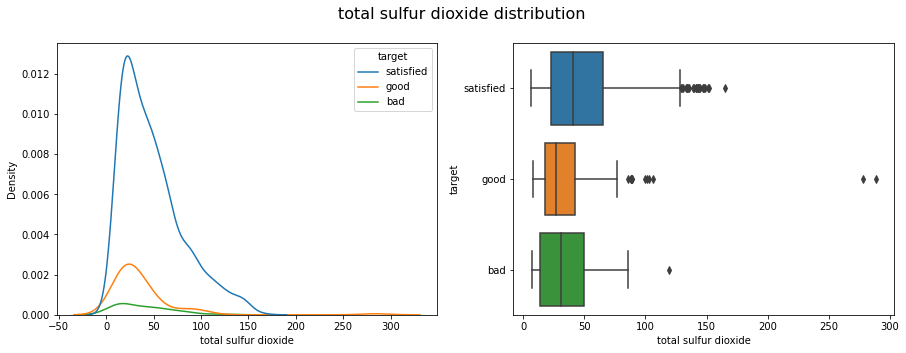

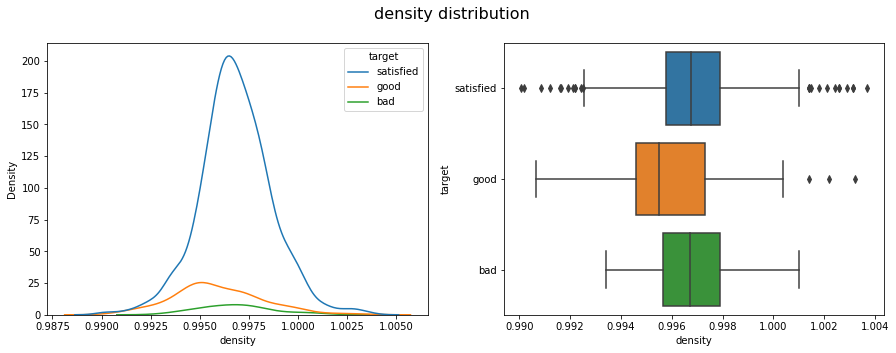

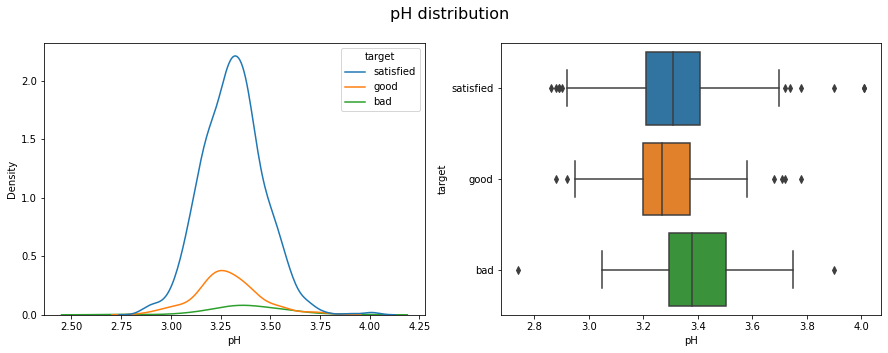

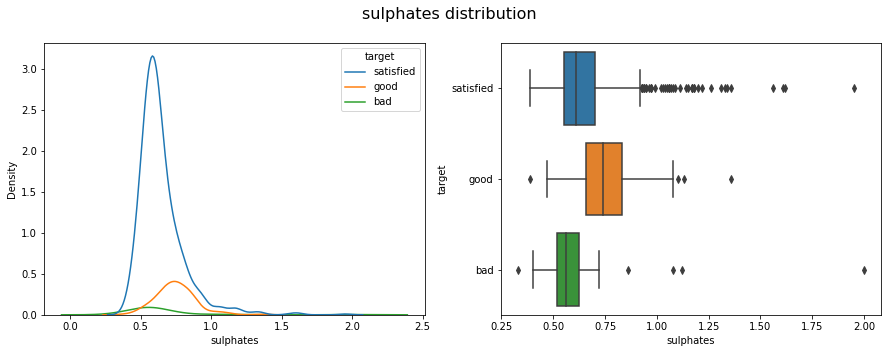

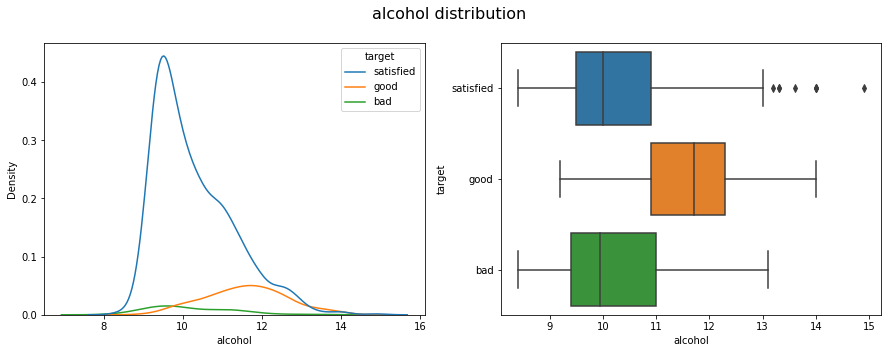

In [15]:
for feature in features:
        fig, axes = plt.subplots(1, 2, figsize=[15, 5])
        fig.suptitle(f'{feature} distribution', fontsize=16)
        sns.kdeplot(data=df_mod, x=feature, hue='target', ax=axes[0])
        sns.boxplot(data=df_mod.astype({'target': str}), y='target', x=feature, ax=axes[1])

Часть распределений "скошены" в область низких значений признаков. Есть выбросы в сторону высоких значений признаков. Тем не менее, явных аномалий в признаках нет. Решение об удалении этих данных на этом этапе принимать не стоит, но можно будет попробовать при "дизайне" модели, если возникнет необходимость.

Явно есть дисбаланс в целевой переменной.

Посмотрим на распределение целевой переменной.


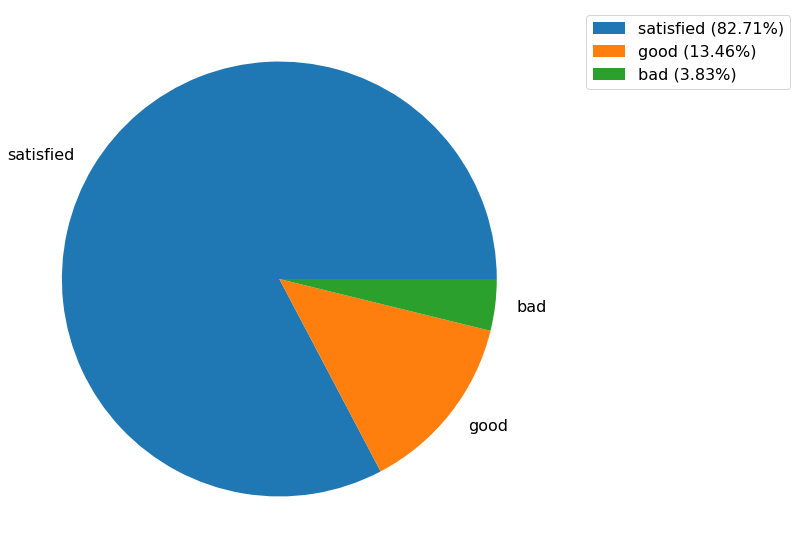

In [16]:
plt.figure(figsize = (10,10))
fig.suptitle('Target distribution', fontsize=16)
target_counts = df_mod['target'].value_counts()
plt.pie(target_counts, labels=target_counts.index, textprops={'fontsize': 16})
legend_entries = [f'{label} ({count/len(df_mod)*100:.2f}%)' for label, count in target_counts.items()]
plt.legend(legend_entries, bbox_to_anchor=(1.05, 1), loc='best', fontsize=16)
plt.show()

Действительно, более 80% датасета относятся к "посредственным" образцам.

Это надо будет учесть при разбиении на тестовую и тренирововчную выборку, по возможности это распределение нужно сохранить.

Посмотрим на матрицу корреляции.

<AxesSubplot: >

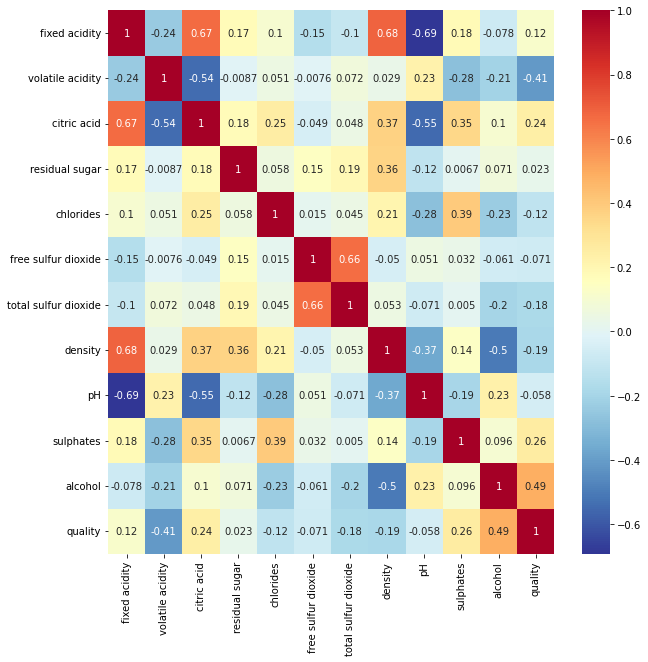

In [17]:
plt.figure(figsize = (10,10))
sns.heatmap(df_uniq.corr(), cmap = "RdYlBu_r", annot = True)

Выведем корелляции целевой переменной с признаками.

Наибольшая положительная корреляция с уровенм алкоголя. Это объяснимо, уровень алкоголя при естественном брожении зависит от уровня сахара в сырье, который в свою очередь повышается в зависимости от зрелости винограда и климата - чем более спелый виноград и благоприятный климат - тем выше.

Наибольшая отрицательная корреляция с летучими кислотами. Это тоже логично - при высоком уровне они дают неприятный вкус. В виноделии их количество сознательно ограничивают.



In [18]:
corr_matrix = df_uniq.corr()
print(corr_matrix['quality'].sort_values(ascending=False),'\n')

quality                 1.000000
alcohol                 0.485953
sulphates               0.257519
citric acid             0.241565
fixed acidity           0.115826
residual sugar          0.022718
pH                     -0.057592
free sulfur dioxide    -0.071083
chlorides              -0.122214
total sulfur dioxide   -0.182214
density                -0.185187
volatile acidity       -0.409340
Name: quality, dtype: float64 



Выведем наиболее скореллированные признаки.

In [19]:
# Threshold for correlation value
threshold = 0.5

# Get the high-correlated pairs of columns, excluding auto-correlations
corr_pairs = (
    corr_matrix[abs(corr_matrix) > threshold][corr_matrix != 1.0]
).unstack().dropna().to_dict()

# Remove duplicate pairs and create a dataframe with unique pairs
unique_corr_pairs = pd.DataFrame(
    list(
        set([(tuple(sorted(key)), corr_pairs[key]) for key in corr_pairs])
    ), columns=['pair', 'corr']
)

# Show the unique pairs and their correlation value
unique_corr_pairs.sort_values(by=['corr'], ascending=False)


,pair,corr
4,"(density, fixed acidity)",0.683120
0,"(citric acid, fixed acidity)",0.668178
2,"(free sulfur dioxide, total sulfur dioxide)",0.661089
6,"(alcohol, density)",-0.504748
1,"(citric acid, volatile acidity)",-0.542459
5,"(citric acid, pH)",-0.553370
3,"(fixed acidity, pH)",-0.692597


Тут объяснимы отрицательные корреляции между кислотами и Ph. Показатель Ph определяет общую кислотность вина, чем ниже, тем меньше килоты.
Также легко объяснима положительная корреляция между общим диокссидом серы и свободным диоксидом серы - чем больше консерванта положили, тем больше растворилось.
Остальная "химия" не настолько очевидна для объяснения.

Применим к данным метод главных компонент

In [20]:
target = []
for qual in df_uniq['quality']:
  if qual > 6:
    targ = 1
  elif qual < 5:
    targ = 3
  else:
    targ = 2
  target.append(targ)
df_mod_new = df_uniq.iloc[:,0:11]
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_mod_new)

In [21]:
model = PCA(n_components = 2)
model.fit(df_scaled)
pca_coords = model.transform(df_scaled)

df_to_draw = pd.DataFrame({
    'class': target,
    'pca1': pca_coords[:, 0],
    'pca2': pca_coords[:, 1]
})
colors = ['b', 'r', 'k' , 'g']

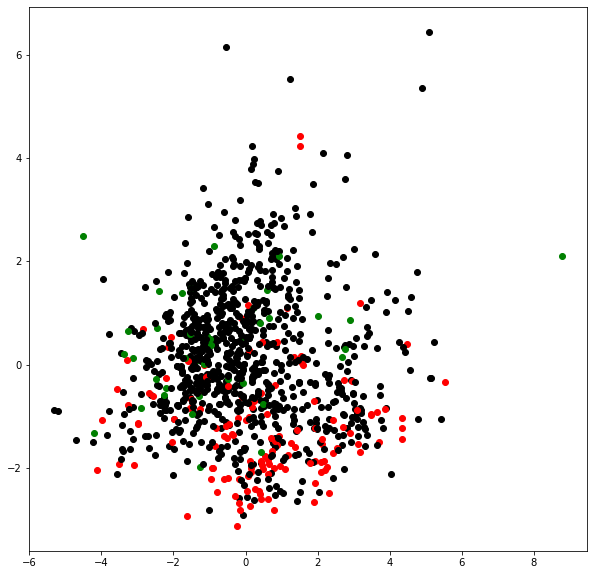

In [22]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)
for f in df_to_draw.iterrows():
  ax.scatter(f[1]['pca1'], f[1]['pca2'], c = colors[int(f[1]['class'])])
  
plt.show()

In [23]:
model = PCA(n_components = 3)
model.fit(df_scaled)
pca_coords = model.transform(df_scaled)

df_to_draw = pd.DataFrame({
    'class': target,
    'pca1': pca_coords[:, 0],
    'pca2': pca_coords[:, 1],
    'pca3': pca_coords[:, 2]
})
colors = ['b', 'r', 'k' , 'g']

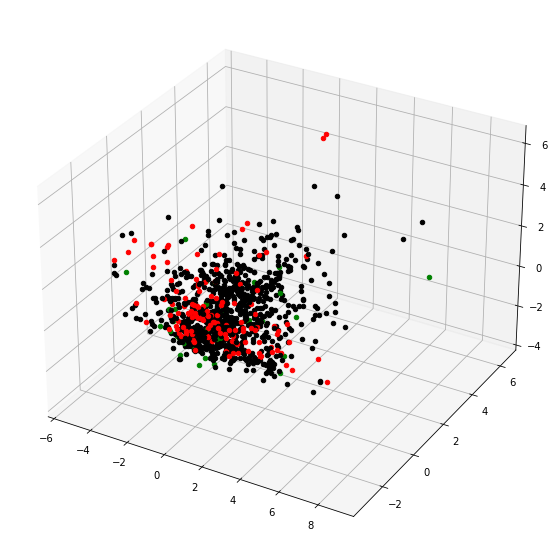

In [24]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = '3d')
for f in df_to_draw.iterrows():
  ax.scatter(f[1]['pca1'], f[1]['pca2'], f[1]['pca3'], c = colors[int(f[1]['class'])])
  
plt.show()

Явной структуры в данных по методу главных компонент не наблюдается.

Попробуем построить бейзлайн модели.

# **3.Построить и оценить качество бейзлайна**

Подготовим данные для наших классификаторов и разделим данные на тренировочные и тестовые выборки.

In [25]:
ohe = OneHotEncoder()
res = ohe.fit_transform(df_mod['target'].to_numpy().reshape(-1, 1))
ohe_df = pd.DataFrame(res.toarray(), columns = ohe.get_feature_names_out())
ohe_df.describe() 

,x0_bad,x0_good,x0_satisfied
count,1018.000000,1018.000000,1018.000000
mean,0.038310,0.134578,0.827112
std,0.192039,0.341440,0.378336
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000
75%,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000


Классификатор для "хорошего" вина:

Разбиваю данные, учитываю их распределение, проверяю распределение данных в выборках

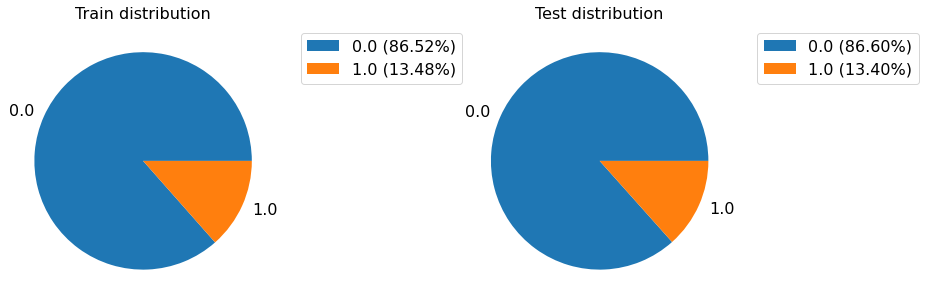

In [26]:
#X1 = df_mod_new
X1 = df_scaled
y1 = ohe_df['x0_good']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=123, test_size=0.3, stratify = y1)

fig, axes = plt.subplots(1, 2, figsize=[15, 5])
axes[0].set_title('Train distribution', fontsize=16)
target_counts = y1_train.value_counts()
axes[0].pie(target_counts, labels=target_counts.index, textprops={'fontsize': 16})
legend_entries = [f'{label} ({count/len(y1_train)*100:.2f}%)' for label, count in target_counts.items()]
axes[0].legend(legend_entries, bbox_to_anchor=(1.05, 1), loc='best', fontsize=16)

axes[1].set_title('Test distribution', fontsize=16)
target_counts = y1_test.value_counts()
axes[1].pie(target_counts, labels=target_counts.index, textprops={'fontsize': 16})
legend_entries = [f'{label} ({count/len(y1_test)*100:.2f}%)' for label, count in target_counts.items()]
axes[1].legend(legend_entries, bbox_to_anchor=(1.05, 1), loc='best', fontsize=16)

Обучаю простые модели

In [27]:
dummy_clf = DummyClassifier(strategy = 'stratified')
dummy_clf.fit(X1_train, y1_train);

log_reg = LogisticRegression(class_weight="balanced")
log_reg.fit(X1_train, y1_train)

y1_pred_dummy = dummy_clf.predict(X1_test)
y1_pred_log_reg = log_reg.predict(X1_test)

Считаю точность и полноту

In [28]:
print(f'Precision for Dummy: {precision_score(y1_test, y1_pred_dummy, zero_division=0)}')
print(f'Precision for Logistic: {precision_score(y1_test, y1_pred_log_reg)}')
print(f'Recall for Dummy: {recall_score(y1_test, y1_pred_dummy, zero_division=0)}')
print(f'Recall for Logistic: {recall_score(y1_test, y1_pred_log_reg)}')

Precision for Dummy: 0.09302325581395349
Precision for Logistic: 0.3465346534653465
Recall for Dummy: 0.0975609756097561
Recall for Logistic: 0.8536585365853658


Считаю F-меры для логической регрессии

In [29]:
f1_score_first = f1_score(y1_test, y1_pred_log_reg)
fbeta_score_first = fbeta_score(y1_test, y1_pred_log_reg, beta = 0.5)
print(f'F1-score for Logistic regression: {f1_score_first}')
print(f'Fbeta-score for Logistic regression: {fbeta_score_first}')

F1-score for Logistic regression: 0.49295774647887325
Fbeta-score for Logistic regression: 0.3932584269662921


Пробую проанализировать зависимость от порога бинаризации

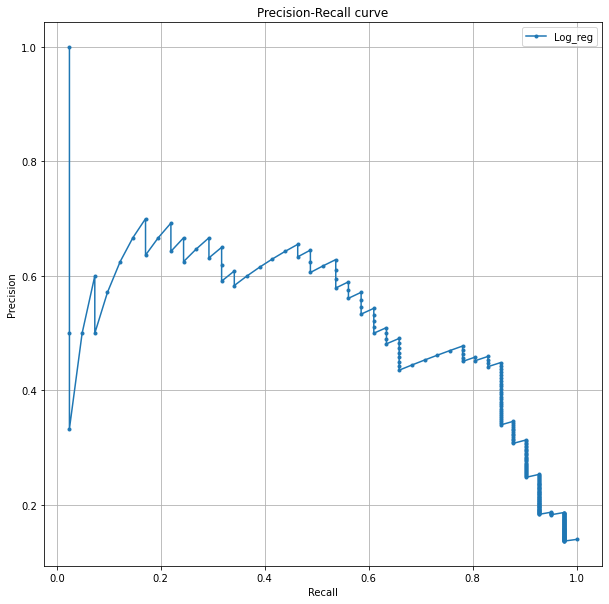

In [30]:
y1_pred = log_reg.predict_proba(X1_test)[:, 1]
precision, recall, thesholds = precision_recall_curve(y1_test, y1_pred)
plt.figure(figsize=(10,10))
plt.plot(recall[:-1], precision[:-1], marker='.', label='Log_reg')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.grid()
plt.show()

По полученным массивам, пробую предположить, что будет если с Fbeta мерой при фиксации Recall >= 0.8

In [31]:
model_log_data = pd.DataFrame({
    'thesholds': thesholds,
    'precision': precision[:-1],
    'recall': recall[:-1]})
model_log_data = model_log_data[model_log_data.recall >= 0.8]
theshold_opt = model_log_data.thesholds[model_log_data.precision.idxmax()]
recall_opt = model_log_data.recall[model_log_data.precision.idxmax()]
precision_opt = model_log_data.precision[model_log_data.precision.idxmax()]
print(f'Optimized values: {[precision_opt, recall_opt, theshold_opt]}')
fbeta_score_first_opt = (0.5**2 + 1) * (recall_opt * precision_opt) / (recall_opt + 0.5**2 * precision_opt)
print(f'Optimized fbeta_score: {fbeta_score_first_opt}')

Optimized values: [0.4594594594594595, 0.8292682926829268, 0.6733069246401747]
Optimized fbeta_score: 0.5044510385756676


Классификатор для "плохого" вина:

Разбиваю данные, проверяю распределение данных в выборках

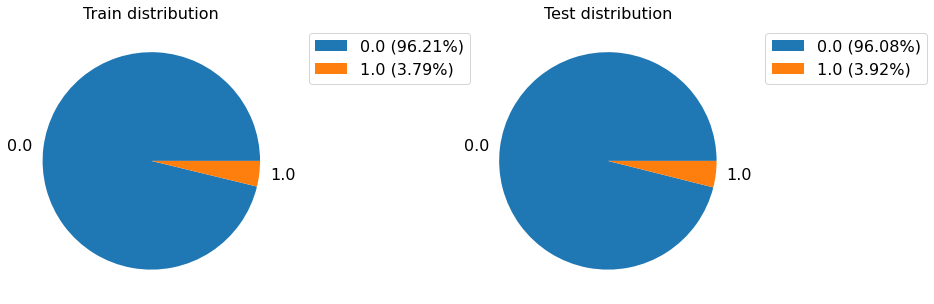

In [32]:
#X1 = df_mod_new
X2 = df_scaled
y2 = ohe_df['x0_bad']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=123, test_size=0.3, stratify = y2)

fig, axes = plt.subplots(1, 2, figsize=[15, 5])
axes[0].set_title('Train distribution', fontsize=16)
target_counts = y2_train.value_counts()
axes[0].pie(target_counts, labels=target_counts.index, textprops={'fontsize': 16})
legend_entries = [f'{label} ({count/len(y2_train)*100:.2f}%)' for label, count in target_counts.items()]
axes[0].legend(legend_entries, bbox_to_anchor=(1.05, 1), loc='best', fontsize=16)

axes[1].set_title('Test distribution', fontsize=16)
target_counts = y2_test.value_counts()
axes[1].pie(target_counts, labels=target_counts.index, textprops={'fontsize': 16})
legend_entries = [f'{label} ({count/len(y2_test)*100:.2f}%)' for label, count in target_counts.items()]
axes[1].legend(legend_entries, bbox_to_anchor=(1.05, 1), loc='best', fontsize=16)

Обучаю простые модели

In [33]:
dummy_clf = DummyClassifier(strategy = 'stratified')
dummy_clf.fit(X2_train, y2_train);

log_reg = LogisticRegression(class_weight="balanced")
log_reg.fit(X2_train, y2_train)

y2_pred_dummy = dummy_clf.predict(X2_test)
y2_pred_log_reg = log_reg.predict(X2_test)

Смотрю точность и полноту

In [34]:
print(f'Precision for Dummy: {precision_score(y2_test, y2_pred_dummy, zero_division=0)}')
print(f'Precision for Logistic: {precision_score(y2_test, y2_pred_log_reg)}')
print(f'Recall for Dummy: {recall_score(y2_test, y2_pred_dummy, zero_division=0)}')
print(f'Recall for Logistic: {recall_score(y2_test, y2_pred_log_reg)}')

Precision for Dummy: 0.125
Precision for Logistic: 0.10256410256410256
Recall for Dummy: 0.08333333333333333
Recall for Logistic: 0.6666666666666666


Считаю F-меры

In [35]:
f1_score_second = f1_score(y2_test, y2_pred_log_reg)
fbeta_score_second = fbeta_score(y2_test, y2_pred_log_reg, beta = 2)
print(f'F1-score for Logistic regression: {f1_score_second}')
print(f'Fbeta-score for Logistic regression: {fbeta_score_second}')

F1-score for Logistic regression: 0.17777777777777778
Fbeta-score for Logistic regression: 0.31746031746031744


Пробую проанализировать зависимость от порога бинаризации

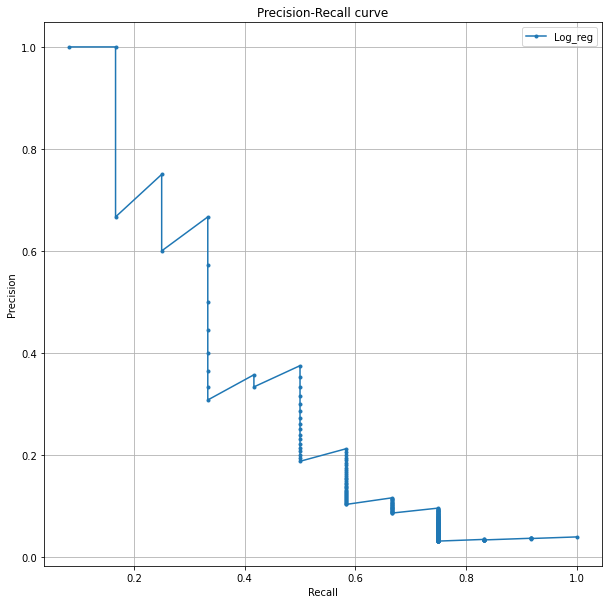

In [36]:
y2_pred = log_reg.predict_proba(X2_test)[:, 1]
precision, recall, thesholds = precision_recall_curve(y2_test, y2_pred)
plt.figure(figsize=(10,10))
plt.plot(recall[:-1], precision[:-1], marker='.', label='Log_reg')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.grid()
plt.show()

По полученным массивам, пробую предположить, что будет если с Fbeta мерой при фиксации Precision >= 0.67

In [37]:
model_log_data = pd.DataFrame({
    'thesholds': thesholds,
    'precision': precision[:-1],
    'recall': recall[:-1]})
model_log_data = model_log_data[model_log_data.precision >= 0.67]
theshold_opt = model_log_data.thesholds[model_log_data.recall.idxmax()]
recall_opt = model_log_data.recall[model_log_data.recall.idxmax()]
precision_opt = model_log_data.precision[model_log_data.recall.idxmax()]
print(f'Optimized values: {[precision_opt, recall_opt, theshold_opt]}')
fbeta_score_second_opt = (2**2 + 1) * (recall_opt * precision_opt) / (recall_opt + 2**2 * precision_opt)
print(f'Optimized fbeta_score: {fbeta_score_second_opt}')

Optimized values: [0.75, 0.25, 0.9354989586027987]
Optimized fbeta_score: 0.28846153846153844


Рассчитываю общую F-меру для бэйзлайна

In [38]:
baseline_score = (fbeta_score_first + fbeta_score_second) / 2
print(f'Quality score for baseline model is: {baseline_score}')
baseline_score_opt = (fbeta_score_first_opt + fbeta_score_second_opt) / 2
print(f'Quality score for baseline model with fixed precision and recall is: {baseline_score_opt}')

Quality score for baseline model is: 0.35535937221330477
Quality score for baseline model with fixed precision and recall is: 0.39645628851860304
